In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import adjustText
import tensorflow_hub as hub
import seaborn as sns
from sklearn.utils import resample

In [2]:
df_data = pd.read_csv('../Data/data_2/clean_review_300k.csv')
df_data

,text,label
0,rip overcharge unsympathetic book stay setai w...,negative
1,room near elevator meet expectation DATE DATE ...,negative
2,horrible service suprise bed wife icon wedding...,negative
3,check always nightmare DATE DATE DATE stay hot...,negative
4,dark literally figuratively ORDINAL good thing...,negative
...,...,...
309686,wonderfully surprising seattle DATE DATE look ...,positive
309687,expect nothing less marriott wife CARDINAL tee...,positive
309688,amazing staff great service GPE meeting stay G...,positive
309689,hide gem stay GPE great front desk staff helpf...,positive


In [3]:
negative_reviews = df_data[df_data['label'] == 'negative']['text']
positive_reviews = df_data[df_data['label'] == 'positive']['text']
neutral_reviews = df_data[df_data['label'] == 'neutral']['text']


all_reviews = df_data['text']

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, max_df=0.5, smooth_idf=True)
tfidf_all = vectorizer.fit_transform(all_reviews)

tfidf_negative = vectorizer.transform(negative_reviews)
tfidf_positive = vectorizer.transform(positive_reviews)
tfidf_neutral = vectorizer.transform(neutral_reviews)

top_words_negative = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_negative.toarray(), axis=0))} 
top_words_positive = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_positive.toarray(), axis=0))}
top_words_neutral = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_neutral.toarray(), axis=0))}

wordcloud_negative = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_negative)
wordcloud_positive = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_positive)
wordcloud_neutral = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_neutral)

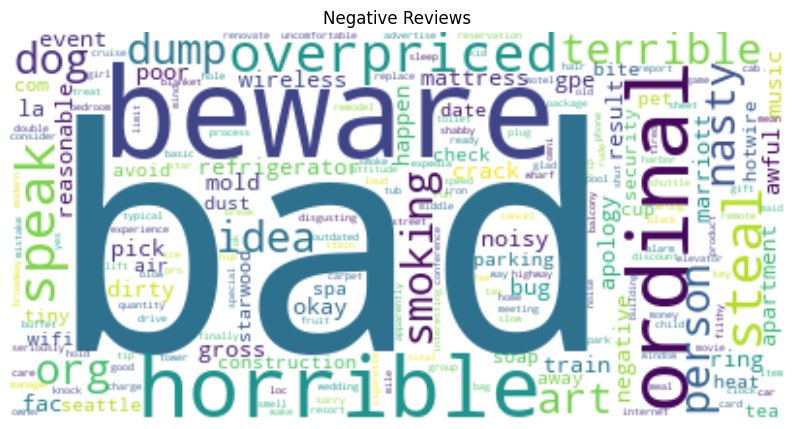

In [4]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis("off")
plt.show()


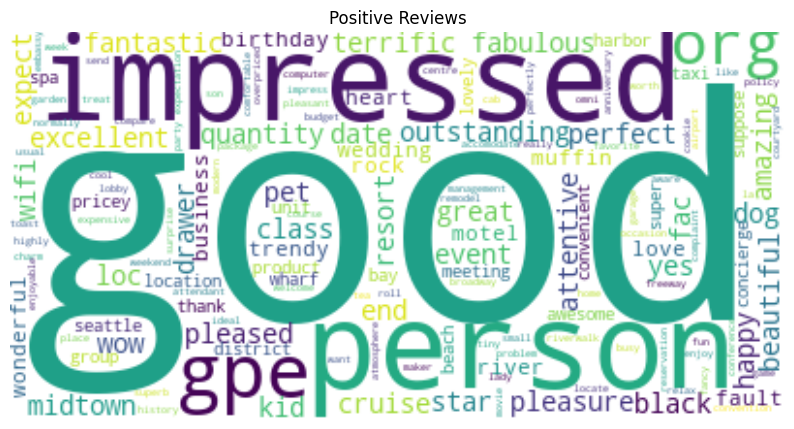

In [5]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis("off")
plt.show()


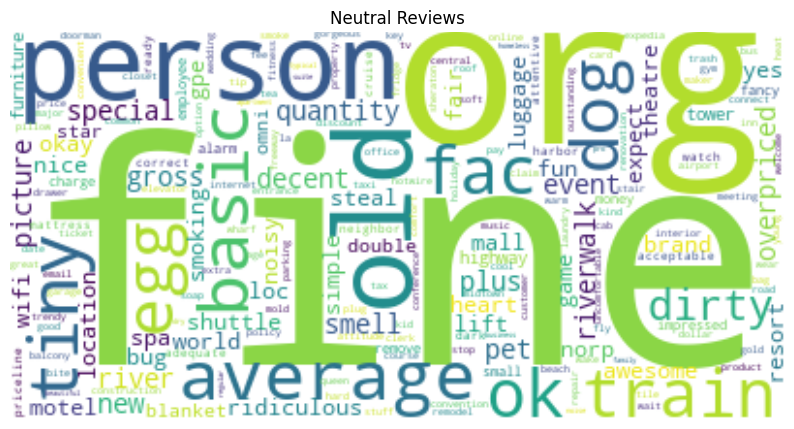

In [6]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews')
plt.axis("off")
plt.show()

In [7]:
encoding_label = {
    'positive': 0,
    'neutral': 1,
    'negative': 2
}


In [8]:
df_data['label'] = df_data['label'].map(encoding_label)
df_data

,text,label
0,rip overcharge unsympathetic book stay setai w...,2
1,room near elevator meet expectation DATE DATE ...,2
2,horrible service suprise bed wife icon wedding...,2
3,check always nightmare DATE DATE DATE stay hot...,2
4,dark literally figuratively ORDINAL good thing...,2
...,...,...
309686,wonderfully surprising seattle DATE DATE look ...,0
309687,expect nothing less marriott wife CARDINAL tee...,0
309688,amazing staff great service GPE meeting stay G...,0
309689,hide gem stay GPE great front desk staff helpf...,0


In [9]:
x_train, x_test, y_train, y_test = train_test_split(df_data['text'], df_data['label'], test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((247752,), (61939,), (247752,), (61939,))

In [10]:
EMBEDDING_DIM = 100
MAXLEN = 100
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 30000
NUM_LABELS = 3

In [11]:
tokenizer = Tokenizer(num_words=MAX_EXAMPLES, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)

In [12]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_EXAMPLES, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_LABELS, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          3000000   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

In [14]:
history = model.fit(x_train_pad, y_train, epochs=5, validation_data=(x_test_pad, y_test), verbose=1)

Epoch 1/5
7743/7743 [==============================] - 1040s 134ms/step - loss: 0.5497 - accuracy: 0.7660 - val_loss: 0.5101 - val_accuracy: 0.7859
Epoch 2/5
7743/7743 [==============================] - 891s 115ms/step - loss: 0.4739 - accuracy: 0.8011 - val_loss: 0.4955 - val_accuracy: 0.7917
Epoch 3/5
7743/7743 [==============================] - 899s 116ms/step - loss: 0.4319 - accuracy: 0.8217 - val_loss: 0.5072 - val_accuracy: 0.7861
Epoch 4/5
7743/7743 [==============================] - 834s 108ms/step - loss: 0.3843 - accuracy: 0.8447 - val_loss: 0.5465 - val_accuracy: 0.7804
Epoch 5/5
7743/7743 [==============================] - 889s 115ms/step - loss: 0.3295 - accuracy: 0.8710 - val_loss: 0.6041 - val_accuracy: 0.7705


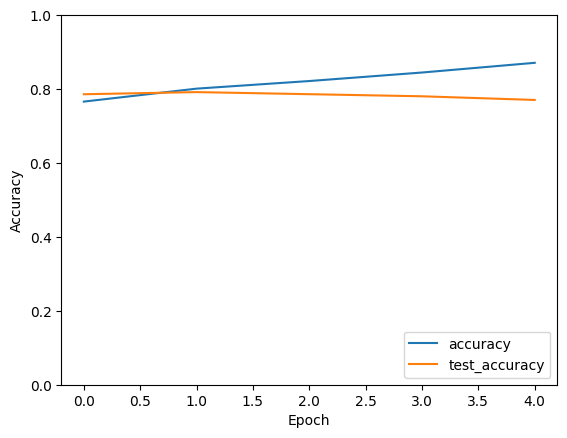

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [16]:
predictions = model.predict(x_test_pad)
predictions = np.argmax(predictions, axis=1)
y_test = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test, predictions)

1936/1936 [==============================] - 42s 21ms/step


In [17]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84     20649
           1       0.68      0.66      0.67     20658
           2       0.78      0.82      0.80     20632

    accuracy                           0.77     61939
   macro avg       0.77      0.77      0.77     61939
weighted avg       0.77      0.77      0.77     61939



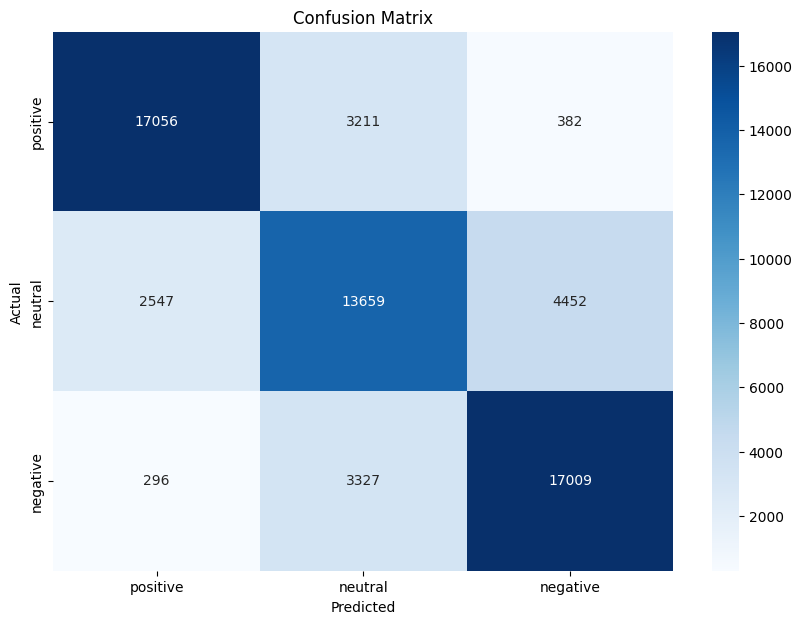

In [18]:
df_confusion_matrix = pd.DataFrame(conf_matrix, index = ['positive', 'neutral', 'negative'], columns = ['positive', 'neutral', 'negative'])
plt.figure(figsize=(10,7))
plt.title('Confusion Matrix')
sns.heatmap(df_confusion_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()